In [8]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import glob 
from sunpy.time import parse_time 
from sunpy import timeseries as ts 
import datetime
from matplotlib import dates
from scipy.signal import savgol_filter
import scipy.stats
import plotly.express as px
import sunpy.map
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import LogNorm
plt.ion()
from astropy.visualization import hist
import seaborn as sns
sns.set_context("paper")

import warnings
warnings.filterwarnings("ignore")

In [9]:
cmap_paper = "viridis"

In [10]:
vlf_flares = pd.read_csv("final_paper_vlf_flares2.csv")
vlf_flares["event_starttime"] = pd.to_datetime(vlf_flares["event_starttime"])

In [11]:
vlf_flares["goes_class_ind"].value_counts()

C    265
M     76
X      2
Name: goes_class_ind, dtype: int64

In [12]:
vlf_flares["event_starttime"].min()

Timestamp('2012-08-30 12:02:00')

In [13]:
def calc_amp(x):
    return 20*np.log10(x + 5) - 61 + 107

def sid_to_series(file, amp=False):

    sid = pd.read_csv(file, comment="#", names=["times", "data"])
    tt = parse_time(sid["times"]).datetime
    if amp:
        ser = pd.Series(calc_amp(sid["data"].values), index=tt)
    else:
        ser = pd.Series(sid["data"].values, index=tt)		
    ser.sort_index(inplace=True)
    return ser

# File patterns
sid_file_dir = "/Users/laurahayes/ionospheric_work/vlf_data_all_birr/sid_alll/*%Y%m%d*NAA*"
goes_file_dir = "/Users/laurahayes/QPP/stats_study/TEBBS/goes_rawdata/*%Y%m%d*.fits"

In [14]:
def get_pandas_df_of_results():
    errors = []
    results = []
    save=True
    for i in range(0, len(vlf_flares)):
        try:
            new_ts = pd.to_datetime(vlf_flares["event_starttime"].iloc[i])-datetime.timedelta(minutes=5)
            new_te = pd.to_datetime(vlf_flares["event_endtime"].iloc[i])+datetime.timedelta(minutes=5)

            # SID data
            sid_file = glob.glob(vlf_flares.iloc[i]["event_starttime"].strftime(sid_file_dir))[0]
            sid_data = sid_to_series(sid_file).truncate(new_ts, new_te)
            sid_data_db = sid_to_series(sid_file, amp=True).truncate(new_ts, new_te)

            # smoothing window defined in terms of cadence
            window_sec =  (sid_data.index[1] - sid_data.index[0]).total_seconds()
            window = int((2*60)/window_sec)
            if window%2 == 0:
                window = window+1

            sid_resample = pd.Series(savgol_filter(sid_data, int(window), 3), index=sid_data.index)
            sid_resample_flare = sid_resample.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])
            sid_resample_db = pd.Series(savgol_filter(sid_data_db, int(window), 3), index=sid_data_db.index)
            sid_resample_flare_db = sid_resample_db.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])                
            # GOES data
            goes_file = glob.glob(pd.to_datetime(vlf_flares["event_starttime"].iloc[i]).strftime(goes_file_dir))[0]
            goes = ts.TimeSeries(goes_file).truncate(new_ts, new_te)
            gl = goes.to_dataframe()["xrsb"]
            gs = goes.to_dataframe()["xrsa"]
            gl_flare = gl.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])
            gs_flare = gs.truncate(vlf_flares["event_starttime"].iloc[i], vlf_flares["event_endtime"].iloc[i])


            peak_vlf = np.max(sid_resample_flare)
            peak_vlf2 = np.abs(np.max(sid_resample_flare) - sid_resample_flare[0])

            peak_vlf_db = np.max(sid_resample_flare_db)
            peak_vlf2_db = np.abs(np.max(sid_resample_flare_db) - sid_resample_flare_db[0])

            dt_value_gl = (sid_resample_flare.index[np.argmax(sid_resample_flare)] - gl_flare.index[np.argmax(gl_flare)]).total_seconds()
            dt_value_gs = (sid_resample_flare.index[np.argmax(sid_resample_flare)] - gs_flare.index[np.argmax(gs_flare)]).total_seconds()

            event = {}
            event["start_time_goes"] = vlf_flares.iloc[i]["event_starttime"]
            event["peak_flare_gl"] = np.max(gl_flare)
            event["peak_flare_gs"] = np.max(gs_flare)
            event["max_vlf"] = peak_vlf
            event["abs_vlf"] = peak_vlf2
            event["max_vlf_db"] = peak_vlf_db
            event["abs_vlf_db"] = peak_vlf2_db
            event["dt_value_gl"] = dt_value_gl
            event["dt_value_gs"] = dt_value_gs


            results.append(event)
        except:
            print("error", i)
    results = pd.DataFrame(results)

    merged_results = pd.merge(results, vlf_flares, left_on="start_time_goes", right_on="event_starttime")
    merged_results.to_csv("vlf_stats_results2.csv", index_label=False)

In [ ]:
# get_pandas_df_of_results()

In [8]:
vlf_stats = pd.read_csv("vlf_stats_results2.csv")
vlf_stats["start_time_goes"] = pd.to_datetime(vlf_stats["start_time_goes"])

In [9]:
vlf_stats[["peak_flare_gl", "goes_class_val"]]

,peak_flare_gl,goes_class_val
0,0.000014,0.000013
1,0.000003,0.000003
2,0.000006,0.000005
3,0.000003,0.000003
4,0.000003,0.000003
...,...,...
338,0.000002,0.000002
339,0.000003,0.000003
340,0.000001,0.000001
341,0.000008,0.000008


# Lets make the paper plots 

### Peak flux/amplitude relationships

Text(0.85, 0.06, 'C.C. 0.70')

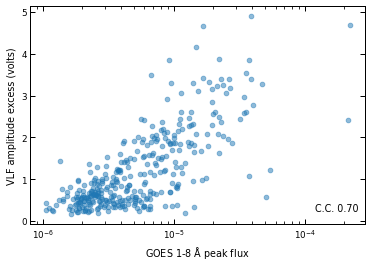

In [10]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf"], alpha=0.5)
ax.set_xscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 1-8 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (volts)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)

#plt.savefig("./paper_plots/goes_long_vlf_volts.png", dpi=300, facecolor="w", bbox_inches="tight")

Text(0.85, 0.06, 'C.C. 0.70')

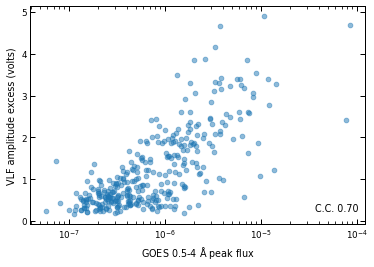

In [11]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf"], alpha=0.5)
ax.set_xscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 0.5-4 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (volts)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)
#plt.savefig("./paper_plots/goes_short_vlf_volts.png", dpi=300, facecolor="w", bbox_inches="tight")

Text(0.85, 0.06, 'C.C. 0.74')

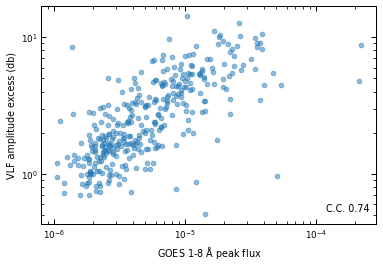

In [12]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 1-8 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (db)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gl"], vlf_stats["abs_vlf_db"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)

#plt.savefig("./paper_plots/goes_long_vlf_db.png", dpi=300, facecolor="w", bbox_inches="tight")

Text(0.85, 0.06, 'C.C. 0.75')

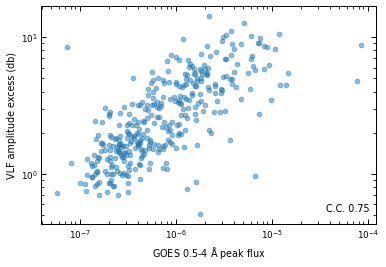

In [13]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlabel("GOES 0.5-4 $\mathrm{\AA}$ peak flux")
ax.set_ylabel("VLF amplitude excess (db)")

cc = scipy.stats.spearmanr(vlf_stats["peak_flare_gs"], vlf_stats["abs_vlf_db"])
ax.text(0.85, 0.06, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)
#plt.savefig("./paper_plots/goes_short_vlf_db.png", dpi=300, facecolor="w", bbox_inches="tight")

### Seasonal and hourly variations

In [14]:
vlf_stats["hour"] = pd.to_datetime(vlf_stats.start_time_goes.dt.strftime("2012-01-01 %H:00"))
vlf_stats["month"] = pd.to_datetime(vlf_stats.start_time_goes.dt.strftime("2012-%b-01 00:00"))

### Hourly

Text(0.5, 0, 'Hour of the Day')

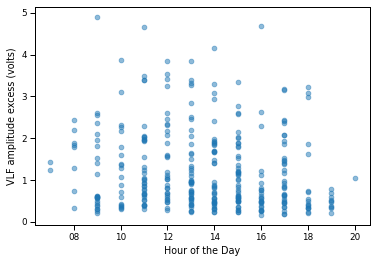

In [15]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["hour"], vlf_stats["abs_vlf"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%H"))
ax.set_ylabel("VLF amplitude excess (volts)")
ax.set_xlabel("Hour of the Day")

#plt.savefig("./paper_plots/hour_day_vlf_volts.png", dpi=300, facecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Hour of the Day')

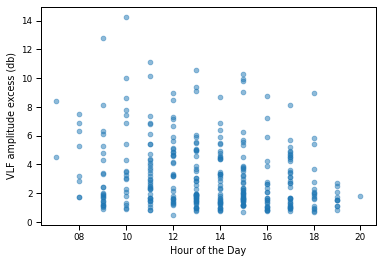

In [16]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["hour"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%H"))
ax.set_ylabel("VLF amplitude excess (db)")
ax.set_xlabel("Hour of the Day")
#plt.savefig("./paper_plots/hour_day_vlf_db.png", dpi=300, facecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Hour of the Day')

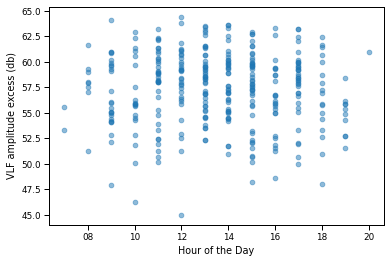

In [17]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["hour"], vlf_stats["max_vlf_db"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%H"))
ax.set_ylabel("VLF amplitude excess (db)")
ax.set_xlabel("Hour of the Day")
#plt.savefig("./paper_plots/hour_day_vlf_db_nodetrend.png", dpi=300, facecolor="w", bbox_inches="tight")

### Seasonal

Text(0.5, 0, 'Month of the Year')

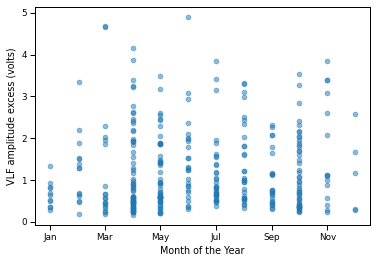

In [18]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["abs_vlf"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude excess (volts)")
ax.set_xlabel("Month of the Year")
#plt.savefig("./paper_plots/seasonal_vlf_volts.png", dpi=300, facecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Month of the Year')

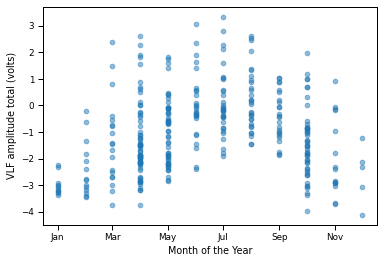

In [19]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["max_vlf"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude total (volts)")
ax.set_xlabel("Month of the Year")

#plt.savefig("./paper_plots/seasonal_vlf_volts_notdetrended.png", dpi=300, facecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Month of the Year')

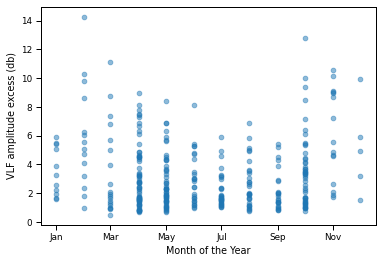

In [20]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["abs_vlf_db"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude excess (db)")
ax.set_xlabel("Month of the Year")

#plt.savefig("./paper_plots/seasonal_vlf_db.png", dpi=300, facecolor="w", bbox_inches="tight")



Text(0.5, 0, 'Month of the Year')

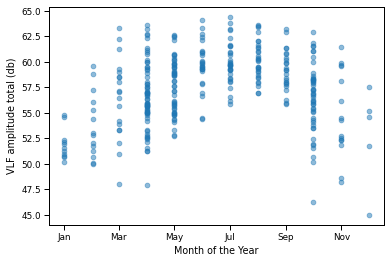

In [21]:
fig, ax = plt.subplots()
ax.scatter(vlf_stats["month"], vlf_stats["max_vlf_db"], alpha=0.5)
ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
ax.set_ylabel("VLF amplitude total (db)")
ax.set_xlabel("Month of the Year")
#plt.savefig("./paper_plots/seasonal_vlf_db_notdetrended.png", dpi=300, facecolor="w", bbox_inches="tight")






### Heliographic Location

In [22]:
ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime="2013-10-28", frame=frames.Helioprojective) 
map_meta = sunpy.map.make_fitswcs_header(np.zeros((2400, 2400)), ref_coord)
blank_map = sunpy.map.Map(np.zeros((2400, 2400)), map_meta)

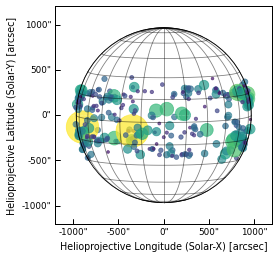

In [23]:
blank_map.plot(alpha=0, title="")
blank_map.draw_limb(color="k")
_ = blank_map.draw_grid(color="k")
ax = plt.gca()
ax.tick_params(which="both", direction="in",)
plt.scatter((vlf_stats["hpc_x"].values*u.arcsec).to(u.deg), (vlf_stats["hpc_y"].values*u.arcsec).to(u.deg),
            transform=ax.get_transform("world"), alpha=0.7, c=np.log10(vlf_stats["goes_class_val"]), 
            s=5e6*(vlf_stats["goes_class_val"]))

#plt.savefig("./paper_plots/positions_of_flares.png", dpi=300, facecolor="w", bbox_inches="tight")




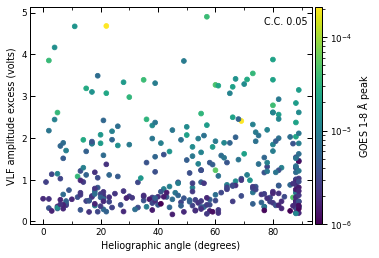

In [24]:
vlf_stats2 = vlf_stats[~vlf_stats["hgs_lon"].isnull()]
fig, ax = plt.subplots()

sc = ax.scatter(np.abs(vlf_stats2["hgs_lon"]), vlf_stats2["abs_vlf"], 
            c=(vlf_stats2["goes_class_val"]), cmap=cmap_paper, norm=LogNorm(),
           )

ax.set_ylabel("VLF amplitude excess (volts)")
ax.set_xlabel("Heliographic angle (degrees)")
ax.tick_params(which="both", direction="in", top=True, right=True)
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))

cc = scipy.stats.spearmanr(np.abs(vlf_stats2["hgs_lon"]), vlf_stats2["abs_vlf"])
ax.text(0.83, 0.92, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax.transAxes)
cbar = fig.colorbar(sc, ax=ax, pad=0.01, aspect=30)
cbar.set_label("GOES 1-8 $\mathrm{\AA}$ peak")
#plt.savefig("./paper_plots/heliographic_corr.png", dpi=300, facecolor="w", bbox_inches="tight")

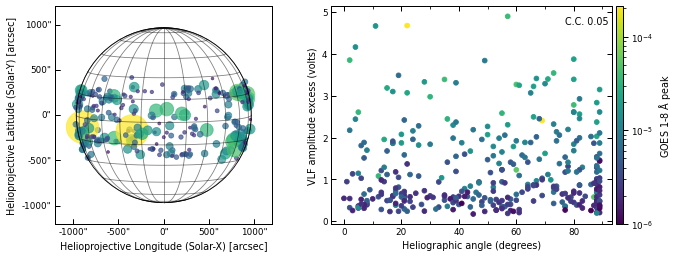

In [25]:
from matplotlib import gridspec
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1.2,1.8])

fig = plt.figure(figsize=(11, 4))
ax1 = fig.add_subplot(spec[0], projection=blank_map)

blank_map.plot(alpha=0, title="", axes=ax1)
blank_map.draw_limb(color="k", axes=ax1)
_ = blank_map.draw_grid(color="k")

ax1.tick_params(which="both", direction="in",)
ax1.scatter((vlf_stats["hpc_x"].values*u.arcsec).to(u.deg), (vlf_stats["hpc_y"].values*u.arcsec).to(u.deg),
            transform=ax1.get_transform("world"), alpha=0.7, c=np.log10(vlf_stats["goes_class_val"]), 
            s=5e6*(vlf_stats["goes_class_val"]))

ax2 = fig.add_subplot(spec[1])

sc = ax2.scatter(np.abs(vlf_stats2["hgs_lon"]), vlf_stats2["abs_vlf"], 
            c=(vlf_stats2["goes_class_val"]), cmap=cmap_paper, norm=LogNorm(),
           )

ax2.set_ylabel("VLF amplitude excess (volts)")
ax2.set_xlabel("Heliographic angle (degrees)")
ax2.tick_params(which="both", direction="in", top=True, right=True)
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(MultipleLocator(10))

cc = scipy.stats.spearmanr(np.abs(vlf_stats2["hgs_lon"]), vlf_stats2["abs_vlf"])
ax2.text(0.83, 0.92, "C.C. {:.2f}".format(round(cc.correlation, 2)), transform=ax2.transAxes)
cbar = fig.colorbar(sc, ax=ax2, pad=0.01, aspect=30)
cbar.set_label("GOES 1-8 $\mathrm{\AA}$ peak")

#plt.savefig("./paper_plots/helio_position_ana.png", facecolor="w", dpi=300, bbox_inches="tight")

### Time Delays

SpearmanrResult(correlation=-0.17217382499504763, pvalue=0.0013695132503036723)
SpearmanrResult(correlation=-0.31014437911859755, pvalue=4.402427345787183e-09)


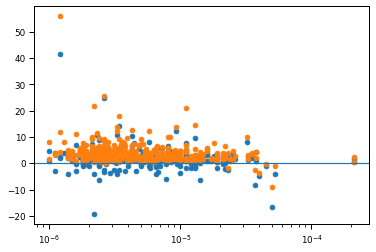

In [26]:
plt.scatter(vlf_stats["goes_class_val"], vlf_stats["dt_value_gl"]/60)
plt.scatter(vlf_stats["goes_class_val"], vlf_stats["dt_value_gs"]/60)
plt.xscale("log")
plt.axhline(0)
# plt.ylim(0, 20)

print(scipy.stats.spearmanr(vlf_stats["peak_flare_gl"], vlf_stats["dt_value_gl"]))
print(scipy.stats.spearmanr(vlf_stats["peak_flare_gs"], vlf_stats["dt_value_gs"]))

In [27]:
vlf_stats[vlf_stats["dt_value_gs"]/60>20][["event_peaktime"]]

,event_peaktime
80,2013-05-31 08:07:00
160,2015-03-14 11:55:00
183,2015-04-23 10:07:00
309,2016-07-19 11:53:00


In [28]:
vlf_stats3 = vlf_stats[vlf_stats["dt_value_gs"]/60<20]

SpearmanrResult(correlation=-0.17530786944020552, pvalue=0.0011912270785709614)
SpearmanrResult(correlation=-0.3000063838403832, pvalue=1.764936718446539e-08)


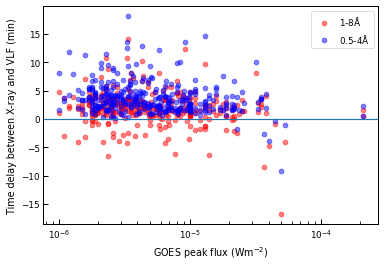

In [29]:
fig, ax = plt.subplots()
plt.scatter(vlf_stats3["goes_class_val"], vlf_stats3["dt_value_gl"]/60, 
            label="1-8$\mathrm{\AA}$", alpha=0.5, color="r")
plt.scatter(vlf_stats3["goes_class_val"], vlf_stats3["dt_value_gs"]/60, 
            label="0.5-4$\mathrm{\AA}$", alpha=0.5, color="b")
plt.xscale("log")
plt.axhline(0)
# plt.ylim(0, 20)
plt.legend()
print(scipy.stats.spearmanr(vlf_stats3["peak_flare_gl"], vlf_stats3["dt_value_gl"]))
print(scipy.stats.spearmanr(vlf_stats3["peak_flare_gs"], vlf_stats3["dt_value_gs"]))

ax.tick_params(which="both", direction="in")
ax.set_xlabel("GOES peak flux (Wm$^{-2}$)")
ax.set_ylabel("Time delay between X-ray and VLF (min)")
plt.savefig("./paper_plots/time_delay.png", dpi=300, facecolor="w", bbox_inches="tight")

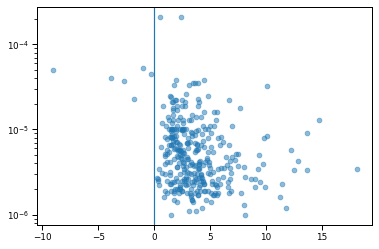

In [30]:
fig, ax = plt.subplots()
# plt.scatter(vlf_stats3["dt_value_gl"]/60, vlf_stats3["goes_class_val"],
#             label="1-8$\mathrm{\AA}$", alpha=0.5)
plt.scatter(vlf_stats3["dt_value_gs"]/60, vlf_stats3["goes_class_val"],
            label="0.5-4$\mathrm{\AA}$", alpha=0.5)
plt.yscale("log")
plt.axvline(0)

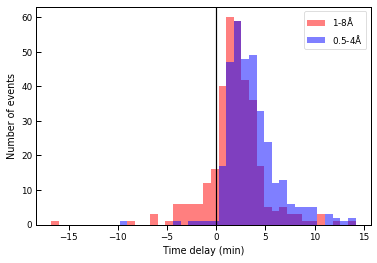

In [33]:
fig, ax = plt.subplots()
_, bins, _ = hist(vlf_stats3["dt_value_gl"]/60, bins=40, alpha=0.5, color="r", label="1-8$\mathrm{\AA}$")
_ = hist(vlf_stats3["dt_value_gs"]/60, bins=bins, alpha=0.5, color="b", label="0.5-4$\mathrm{\AA}$")
plt.axvline(0, color="k")
ax.tick_params(axis="y", direction="in")
ax.set_ylabel("Number of events")
ax.set_xlabel("Time delay (min)")
ax.legend()
plt.savefig("./paper_plots/hist_timedelay.png", dpi=300, facecolor="w", bbox_inches="tight")

median is 3.22 minutes
mean is 3.72 minutes


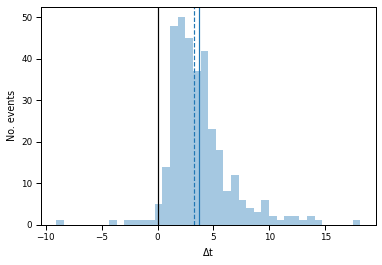

In [34]:
# sns.distplot(vlf_stats3["dt_value_gl"]/60)

fig, ax = plt.subplots()
sns.distplot(vlf_stats3["dt_value_gs"]/60, kde=False, bins=40)
plt.axvline(np.mean(vlf_stats3["dt_value_gs"]/60), color="tab:blue")
plt.axvline(np.median(vlf_stats3["dt_value_gs"]/60), color="tab:blue", ls="dashed")
plt.axvline(0, color="k")
ax.set_xlabel("$\Delta$t")
ax.set_ylabel("No. events")
print("median is {:.02f} minutes".format(np.median(vlf_stats3["dt_value_gs"]/60)))
print("mean is {:.02f} minutes".format(np.mean(vlf_stats3["dt_value_gs"]/60)))

In [47]:
vlf_stats[vlf_stats["dt_value_gl"]<0]

,start_time_goes,peak_flare_gl,peak_flare_gs,max_vlf,abs_vlf,max_vlf_db,abs_vlf_db,dt_value_gl,dt_value_gs,index,...,position_hgs,hgs_lat,hgs_lon,hpc_x,hpc_y,event_end,peak_hour,unique_day,hour,month
6,2012-09-08 17:35:00,0.000015,2.579900e-06,0.148594,2.084849,60.233059,4.510562,-385.972000,222.275000,40,...,NaN,NaN,NaN,NaN,NaN,2012-09-08 18:20:00,17,2012-09-08,2012-01-01 17:00:00,2012-09-01
16,2012-11-20 15:18:00,0.000003,3.437400e-07,-3.707745,0.233433,48.224689,1.729364,-164.555000,44.338000,178,...,N05E19,5.0,-19.0,-316.313351,50.623604,2012-11-20 15:41:00,15,2012-11-20,2012-01-01 15:00:00,2012-11-01
20,2013-01-11 14:51:00,0.000011,1.573000e-06,-3.219911,0.836259,51.008938,5.513013,-70.449000,97.485000,273,...,N06E44,6.0,-44.0,-676.047154,153.482495,2013-01-11 15:24:00,15,2013-01-11,2012-01-01 14:00:00,2012-01-01
25,2013-02-24 13:17:00,0.000003,3.548900e-07,-2.097380,1.282531,55.254847,5.065400,-193.579000,21.461000,317,...,N07W88,7.0,88.0,961.420321,121.377633,2013-02-24 14:57:00,14,2013-02-24,2012-01-01 13:00:00,2012-02-01
26,2013-03-02 14:59:00,0.000002,1.743400e-07,-2.424437,0.440740,54.216911,1.630784,-19.609000,148.325000,318,...,N08E88,8.0,-88.0,-957.788389,137.830188,2013-03-02 15:26:00,15,2013-03-02,2012-01-01 14:00:00,2012-03-01
29,2013-04-07 16:49:00,0.000002,1.130500e-07,-3.167972,0.168486,51.257565,0.837708,-16.199000,196.788000,353,...,N09W45,9.0,45.0,671.238260,221.276837,2013-04-07 17:09:00,16,2013-04-07,2012-01-01 16:00:00,2012-04-01
30,2013-04-18 17:56:00,0.000007,7.527500e-07,-2.166204,1.175453,55.047050,4.654451,-255.105001,88.951000,386,...,N11W88,11.0,88.0,937.087452,184.506288,2013-04-18 19:04:00,18,2013-04-18,2012-01-01 17:00:00,2012-04-01
56,2013-05-03 16:39:00,0.000014,1.766900e-06,-0.102232,2.297721,60.196712,5.897316,-73.429000,184.618000,454,...,N11W38,11.0,38.0,577.000358,231.898317,2013-05-03 17:22:00,16,2013-05-03,2012-01-01 16:00:00,2012-05-01
58,2013-05-04 16:07:00,0.000002,1.152800e-07,-1.857986,0.259528,55.942653,0.749380,-52.889000,196.961000,459,...,N12W53,12.0,53.0,745.008130,234.974092,2013-05-04 16:44:00,16,2013-05-04,2012-01-01 16:00:00,2012-05-01
62,2013-05-10 12:37:00,0.000014,1.820400e-06,0.475631,2.611123,60.768148,5.627794,-104.602000,79.715000,484,...,N12E89,12.0,-89.0,-928.966698,198.081208,2013-05-10 13:04:00,12,2013-05-10,2012-01-01 12:00:00,2012-05-01


In [46]:
vlf_stats["dt_value_gl"].min()

-1159.429

In [ ]:
test = vlf_stats[vlf_stats["hpc_x"].isnull()]

In [ ]:
plt.plot(test["goes_class_val"], test["abs_vlf"], marker='x', ls='')
plt.xscale("log")

In [90]:
scipy.stats.spearmanr(test["goes_class_val"], test["abs_vlf"])

SpearmanrResult(correlation=0.8571428571428573, pvalue=0.01369732661532562)

In [93]:
len(vlf_stats["unique_day"].unique())

192

In [94]:
len(vlf_stats)

342

In [101]:
vlf_stats.groupby("unique_day")["max_vlf"].count().sort_values(ascending=False).head(20)

unique_day
2015-09-27    6
2015-05-05    6
2015-06-11    6
2015-10-02    6
2016-07-24    5
2015-03-11    5
2015-04-21    5
2017-04-02    5
2013-04-23    4
2013-05-10    4
2013-05-19    4
2013-05-23    4
2013-04-25    4
2015-05-07    4
2013-07-05    4
2013-04-26    3
2015-08-28    3
2016-05-14    3
2013-11-07    3
2015-10-15    3
Name: max_vlf, dtype: int64

In [71]:
def plot_day(date):
    test = vlf_stats[vlf_stats["unique_day"].isin([date])]
    print(scipy.stats.spearmanr(test["goes_class_val"], test["abs_vlf"]))
    plt.plot(test["goes_class_val"], test["abs_vlf"], marker='x', ls='')
    plt.xscale("log")
    plt.xlim(1e-6, 1e-3)
    

SpearmanrResult(correlation=0.942857142857143, pvalue=0.004804664723032055)
SpearmanrResult(correlation=0.3714285714285715, pvalue=0.46847813411078715)
SpearmanrResult(correlation=0.6377481392176932, pvalue=0.17307111024125976)
SpearmanrResult(correlation=0.5217939320872036, pvalue=0.28834323380039373)
SpearmanrResult(correlation=0.8999999999999998, pvalue=0.03738607346849874)
SpearmanrResult(correlation=0.39999999999999997, pvalue=0.5046315754686911)
SpearmanrResult(correlation=0.6668859288553503, pvalue=0.21889398131323154)


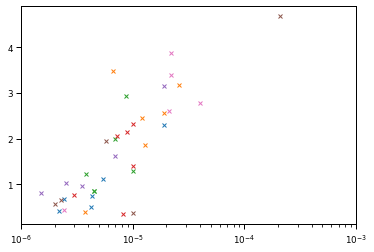

In [72]:
plot_day("2015-09-27")
plot_day("2015-05-05")
plot_day("2015-06-11")
plot_day("2015-10-02")
plot_day("2016-07-24")
plot_day("2015-03-11")
plot_day("2015-04-21")

SpearmanrResult(correlation=0.9999999999999999, pvalue=nan)
SpearmanrResult(correlation=0.942857142857143, pvalue=0.004804664723032055)


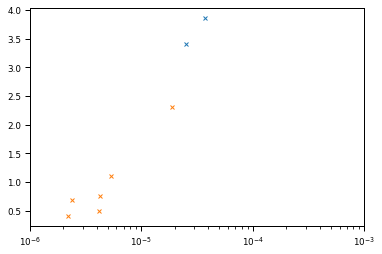

In [74]:
plot_day("2015-11-04")
plot_day("2015-09-27")

In [70]:
vlf_stats[vlf_stats["start_time_goes"]>"2015-11-04 08:00"]

,start_time_goes,peak_flare_gl,peak_flare_gs,max_vlf,abs_vlf,max_vlf_db,abs_vlf_db,dt_value_gl,dt_value_gs,index,...,position_hgs,hgs_lat,hgs_lon,hpc_x,hpc_y,event_end,peak_hour,unique_day,hour,month
282,2015-11-04 11:55:00,0.000026,6.005800e-06,-0.059051,3.400449,59.876928,10.124222,86.221000,84.175000,2825,...,N15W71,15.0,71.0,884.674000,228.444054,2015-11-04 12:06:00,12,2015-11-04,2012-01-01 11:00:00,2012-11-01
283,2015-11-04 13:31:00,0.000037,7.252800e-06,0.930096,3.853470,61.460627,9.115215,-503.125000,-163.159000,2826,...,N08W02,8.0,2.0,33.582236,66.731250,2015-11-04 14:13:00,13,2015-11-04,2012-01-01 13:00:00,2012-11-01
284,2015-12-12 13:36:00,0.000008,1.265400e-06,-2.297514,1.175340,54.635352,4.959245,-6.879000,113.951000,2860,...,N11E81,11.0,-81.0,-945.217891,187.407687,2015-12-12 13:57:00,13,2015-12-12,2012-01-01 13:00:00,2012-12-01
285,2016-01-28 11:48:00,0.000010,1.245300e-06,-3.023506,0.913879,51.917002,5.391024,120.841000,223.241000,2913,...,N03W47,3.0,47.0,713.674768,117.097706,2016-01-28 12:16:00,12,2016-01-28,2012-01-01 11:00:00,2012-01-01
286,2016-02-12 10:36:00,0.000011,2.187600e-06,-3.403081,1.287281,50.065403,14.253280,39.995000,169.018000,2932,...,N11W14,11.0,14.0,231.780442,293.123754,2016-02-12 10:53:00,10,2016-02-12,2012-01-01 10:00:00,2012-02-01
287,2016-02-12 17:10:00,0.000007,9.934701e-07,-3.424180,0.657694,49.949989,4.692897,98.008000,132.825000,2933,...,N11W18,11.0,18.0,296.021639,291.147639,2016-02-12 17:27:00,17,2016-02-12,2012-01-01 17:00:00,2012-02-01
288,2016-02-13 15:16:00,0.000019,3.324400e-06,-0.203244,3.332565,59.619245,10.308033,92.111000,100.301000,2936,...,N14W28,14.0,28.0,444.287583,332.379084,2016-02-13 15:26:00,15,2016-02-13,2012-01-01 15:00:00,2012-02-01
289,2016-02-15 10:41:00,0.000012,2.091800e-06,-2.808144,1.379184,52.815037,8.618004,96.411000,120.985000,2944,...,N11W54,11.0,54.0,773.297707,251.213780,2016-02-15 11:06:00,11,2016-02-15,2012-01-01 10:00:00,2012-02-01
290,2016-02-15 14:40:00,0.000003,3.069600e-07,-2.375027,0.498676,54.382880,1.831264,-256.902000,818.285000,2945,...,N11W60,11.0,60.0,827.427787,241.198844,2016-02-15 15:13:00,15,2016-02-15,2012-01-01 14:00:00,2012-02-01
291,2016-02-15 17:14:00,0.000003,3.013900e-07,-3.285547,0.182705,50.681530,0.978898,18.451000,22.545000,2946,...,N11W57,11.0,57.0,801.440322,246.355109,2016-02-15 17:27:00,17,2016-02-15,2012-01-01 17:00:00,2012-02-01


vlf_stats

In [75]:
vlf_stats["start_time_goes"].min()

Timestamp('2012-08-30 12:02:00')

In [76]:
vlf_stats["start_time_goes"].max()

Timestamp('2018-02-10 13:02:00')

In [79]:
vlf_stats["year"] = vlf_stats["start_time_goes"].dt.strftime("%Y")

In [80]:
vlf_stats["year"].value_counts()

2015    136
2013    120
2016     38
2012     20
2017     17
2014      9
2018      2
Name: year, dtype: int64